In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

"""
The data can be found here: https://www.kaggle.com/nsharan/h-1b-visa/data
These analyses have been performed on a clean version of these data. 
A full accounting of how the data were cleaned can be found here: 
https://github.com/Liptoni/Springboard/blob/master/H1B_Capstone/H1B_Data_Wrangling.docx
"""
hb_data = pd.read_csv('h1b_clean.csv', index_col='CASE_NUMBER')

#need to create these in order to join with census data
hb_data['lat_round'] = hb_data['lat'].apply(lambda x: round(x, 4))
hb_data['lon_round'] = hb_data['lon'].apply(lambda x: round(x, 4))

print(hb_data.info(null_counts=True))

C:\Users\Ian\AppData\Roaming\Python\Python36\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912628 entries, 1 to 3002393
Data columns (total 16 columns):
CASE_STATUS           2912628 non-null object
EMPLOYER_NAME         2912610 non-null object
SOC_NAME              2895555 non-null object
JOB_TITLE             2912618 non-null object
FULL_TIME_POSITION    2912627 non-null object
PREVAILING_WAGE       2912575 non-null float64
YEAR                  2912628 non-null int64
WORKSITE              2912628 non-null object
lon                   2809785 non-null float64
lat                   2809785 non-null float64
CERTIFIED             2912628 non-null object
CITY                  2912487 non-null object
STATE                 2909177 non-null object
LOG_WAGE              2912575 non-null float64
lat_round             2809785 non-null float64
lon_round             2809785 non-null float64
dtypes: float64(6), int64(1), object(9)
memory usage: 377.8+ MB
None


### How many applications were certified or denied? Were there a large number of applications that were certified and then subsequently withdrawn?

In [13]:
print(hb_data.groupby(['CERTIFIED'])['CASE_STATUS'].value_counts())

CERTIFIED  CASE_STATUS        
certified  CERTIFIED              2615623
           CERTIFIED-WITHDRAWN     202659
denied     DENIED                   94346
Name: CASE_STATUS, dtype: int64


In [90]:
print("total certified:", 2615623+202659)
print("percent certified:", (2615623+202659)/2912628)
print("percent certified and withdrawn:",202659/2615623*100)

total certified: 2818282
percent certified: 0.9676079471872138
percent certified and withdrawn: 7.74802026132971


Based on these finding is looks like most (2,818,282 of 2,912,628 (96.8%)) applications were ultimately certified. While there were a large number of applications that were certified and subsequently denied, this number (202,659) made up just under 8% of the total certified applications.

### Were there any trends in the proportions of certified applications by year?

In [19]:
status_by_year = hb_data.groupby(['YEAR'])['CERTIFIED'].value_counts(normalize = True)

print(status_by_year)

YEAR  CERTIFIED
2011  certified    0.916452
      denied       0.083548
2012  certified    0.947896
      denied       0.052104
2013  certified    0.971833
      denied       0.028167
2014  certified    0.976368
      denied       0.023632
2015  certified    0.981773
      denied       0.018227
2016  certified    0.985341
      denied       0.014659
Name: CERTIFIED, dtype: float64


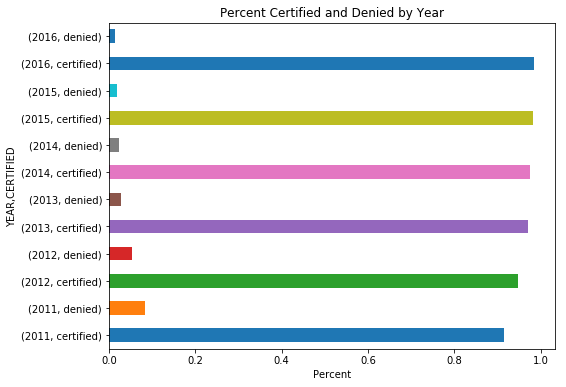

In [48]:
status_by_year.plot(kind='barh', figsize=(8,6))
plt.xlabel('Percent')
plt.title('Percent Certified and Denied by Year')
plt.show()

There actually was an increasing trend in the number of applicaitons that were certified every year from 2011 to 2016. In 2011 91.6% of applications were certified whereas in 2016 over 98.5% of applications were certified.

### What is the distribution of wages associated with applicaitons

First I want to remove applications that had no wage reported. It is unrealistic that someone would take a job paying $0 so I can only assume that these applications are either incomplete or erroneous. Either way they are not appropriate to include in this early visualization.

In [46]:
clean_wage = hb_data[hb_data.PREVAILING_WAGE !=0]

clean_wage.PREVAILING_WAGE.describe()

count    2.912549e+06
mean     1.428927e+05
std      5.282352e+06
min      1.516000e+01
25%      5.441300e+04
50%      6.500000e+04
75%      8.143200e+04
max      6.997607e+09
Name: PREVAILING_WAGE, dtype: float64

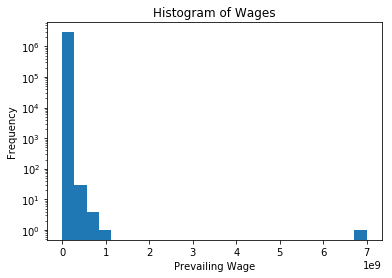

In [84]:
clean_wage.PREVAILING_WAGE.plot(kind='hist', logy=True, bins=25)
plt.title('Histogram of Wages')
plt.xlabel('Prevailing Wage')
plt.show()

Based on this preliminary histogram, it would appear that there are a handfull of extremely high wages that are skewing the distribution. This leads to the question...

#### What is the distribution of wages on the left side of the distribution?

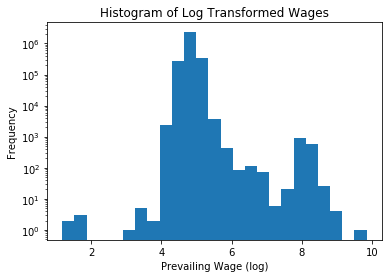

In [86]:
clean_wage.LOG_WAGE.plot(kind='hist', logy=True, bins=25)
plt.title('Histogram of Log Transformed Wages')
plt.xlabel('Prevailing Wage (log)')
plt.show()

When looking at a distribution of log-transformed wages, it seems as if there is potentially a bi-modal distribution. The first is centered near \$10,000 and the second near \$10,000,000. This would indicate that there might be two distinct group of people who are applying for jobs via an H1B visa. 

### Are there any trends in the number of applications for part-time vs. full-time positions?

In [66]:
ft_by_year = hb_data.groupby(['YEAR'])['FULL_TIME_POSITION'].value_counts(sort=False)
ft_by_year

YEAR  FULL_TIME_POSITION
2011  N                      16089
      Y                     332573
2012  N                      15138
      Y                     389744
2013  N                      13145
      Y                     417364
2014  N                      13645
      Y                     489745
2015  N                      14522
      Y                     584750
2016  N                     339006
      Y                     286906
Name: FULL_TIME_POSITION, dtype: int64

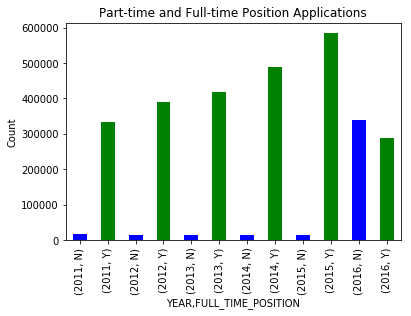

In [93]:
my_colors = ['b', 'g','b', 'g','b', 'g','b', 'g','b', 'g','b', 'g']
plt.ylabel('Count')
plt.title('Part-time and Full-time Position Applications')
ft_by_year.plot(kind='bar', color=my_colors)
plt.show()

This is very interesting. For the years 2011-2015, the vast majority of applications were for full-time employment. Then, in 2016, thre is a drastic change. There were actually more part-time applications than full-time applications. This leads to a larger question which is: Was there some external force that influenced whether visa seekers were looking for part-time vs. full-time employment?

### Is there a correlation between prevailing wage a county population?

In [3]:
#import census data
census_cols = ['ID1', 'ID', 'lat', 'lon', 'block_fips', 'block_pop_2015', 'county_fips', 'county_name', 'state_code', 'state_fips', 'state_name', 'county_pop', 'GEONAME']
census_data = pd.read_csv('county_pop.csv', header=0, names=census_cols)
census_data['lat_round'] = census_data['lat'].apply(lambda x: round(x, 4))
census_data['lon_round'] = census_data['lon'].apply(lambda x: round(x, 4))
census_data = census_data[['ID', 'lat_round', 'lon_round', 'block_fips', 'block_pop_2015', 'county_fips', 'county_name', 'county_pop', 'state_code', 'state_fips', 'state_name']]


In [6]:
#merge census data with h1b data
hb_census = hb_data.merge(census_data, how='left', left_on=['lat_round', 'lon_round'], right_on=['lat_round', 'lon_round'])
hb_census = hb_census[['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'LOG_WAGE', 'CERTIFIED', 'county_pop']]


In [8]:
def get_least_squares(x, y):
    """
    Takes an x-data array and y-data array
    Returns x and y data for least squares line
    """
    slope, intercept = np.polyfit(x, y, 1)
    ls_x = np.array([0,x.max()])
    ls_y = slope*ls_x + intercept
    return ls_x, ls_y

In [9]:
def pearson_r(x_data, y_data):
    """
    Takes x and y data arrays
    Returns the pearson r coefficient
    """
    corr_matrix = np.corrcoef(x_data, y_data)
    return corr_matrix[0,1]

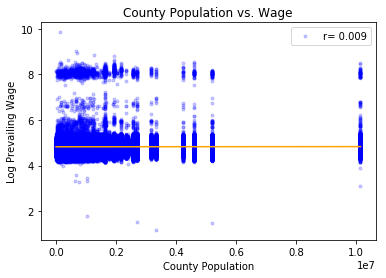

In [11]:
#get a clean dataset for making the correlation plot
clean_hb_census = hb_census[(hb_census.PREVAILING_WAGE.notnull()) & (hb_census.PREVAILING_WAGE != 0) & (hb_census.county_pop.notnull())]

#separate out the parameters
county_pop = clean_hb_census['county_pop']
wages = clean_hb_census['LOG_WAGE']

#get the least squares line and Pearson R
pop_wage_x, pop_wage_y = get_least_squares(county_pop, wages)
pop_wage_r = pearson_r(county_pop, wages)

#make the plot
plot_label = "r= " + str(round(pop_wage_r, 3))
plt.xlabel('County Population')
plt.ylabel('Log Prevailing Wage')
plt.title('County Population vs. Wage')
plt.plot(county_pop, wages, linestyle='none', marker = '.', alpha=0.2, color='b', label=plot_label)
plt.plot(pop_wage_x, pop_wage_y, color='orange')
plt.legend()
plt.show()

There is almost no correlation between the size of a county's population and the prevailing wage of jobs that are being applied to in those counties.